In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
import os
import warnings
import scipy
import pyarrow as pa 
import pyarrow.parquet as pq
from numpy.linalg import inv
warnings.filterwarnings('ignore')

In [ ]:
path='/Users/hmt/Documents/PHBS/courses/investment/project/data/wind底层库数据'

# 数据预处理

In [3]:
#数据读取
all_ashare = pd.read_csv(f'{path}/all_ashares_年报填充_copy.csv',dtype={'交易状态':str, '交易状态码':str,'涨跌停状态':str, 
                                                          'ST状态':str, '申万行业代码':str, 'stkcd':str, '公司名称':str,
                                                          '交易所':str, '上市板块代码':str, '上市时间':str, '退市时间':str,
                                                          '上市板块':str, '是否沪股通':str})
all_stock = all_ashare[['WINDCODE','date','复权preclose','复权open', 
                        '复权high', '复权low','复权close','preclose','open',
                        'high','low','close','交易状态','总市值',
                        '流通市值','PB','公告日期','总资产增长率','每股净资产',
                        'roe','净资产收益率(扣除非经常损益)','申万行业代码','公司名称','交易所','上市板块']].copy()
del all_ashare

## 1.初步预处理

In [4]:
all_stock['date'] = pd.to_datetime(all_stock['date'])
all_stock['公告日期'] = pd.to_datetime(all_stock['公告日期'])
#股价行情时间裁剪，选取 19990101 到 20240101,为了前填数值
cutoff_date_up = pd.to_datetime('20240101')
cutoff_date_down = pd.to_datetime('19990101')
# 使用布尔索引来选择date小于或等于20240101的行
all_stock = all_stock[all_stock['date'] <= cutoff_date_up]
all_stock = all_stock[all_stock['date'] >= cutoff_date_down]

#计算一下前一个交易日的PB,#可以选用的一种 PB计算方式
#all_stock.sort_values(by=['WINDCODE', 'date'], inplace=True)
#可以先用饿的一种 PB 调用方式
#all_stock['PrePB'] = all_stock.groupby(['WINDCODE'])['PB'].shift(1)
#all_stock['PB_other'] = all_stock['PrePB']


In [5]:
#计算PB值
all_stock['PB_other'] = np.where(
    (all_stock['date'] == all_stock['公告日期']), 
    all_stock['preclose'] / all_stock['每股净资产'], 
    np.nan
)

#把每日行情的PB_other都向前填充最近一个公告日报告的财务数据
def ffill_series(group):
    return group.fillna(method='ffill')
columns_to_fill = ['PB_other']
grouped = all_stock.groupby('WINDCODE')
filled_data = grouped[columns_to_fill].apply(ffill_series).reset_index(level=0, drop=True)
for column in columns_to_fill:
    all_stock[column] = filled_data[column]

In [6]:
#清洗非交易数据
condition  = ((all_stock['交易状态']=='交易') | (all_stock['交易状态']=='XR') | 
             (all_stock['交易状态']=='XD') | (all_stock['交易状态']=='DR') |
            (all_stock['交易状态']=='N'))
all_stocks_cleaned = all_stock[condition]
all_stocks_cleaned['date'] = pd.to_datetime(all_stocks_cleaned['date'])

In [7]:
#剔除新上市股票前 30 个交易日的数据
all_stocks_cleaned['次新股'] = all_stocks_cleaned[all_stocks_cleaned['交易状态']=='N']['交易状态']
all_stocks_cleaned['次新股'] = all_stocks_cleaned.groupby('WINDCODE')['次新股'].transform(
    lambda x: x.fillna(method='ffill', limit=30))
all_stocks_cleaned = all_stocks_cleaned[all_stocks_cleaned['次新股'].isna()]

## 2.转化为月度股价行情序列

In [8]:
#聚合函数按WINDCODE，月份
all_stocks_cleaned['period'] = all_stocks_cleaned['date'].dt.to_period('M')
all_stocks_cleaned.sort_values(by=['WINDCODE','date'],inplace=True)
gb = all_stocks_cleaned.groupby(['WINDCODE', 'period'], as_index=False)

In [40]:
monthly_stocks = gb.agg({'复权preclose':'first', 
                         '复权open':'first', 
                         '复权high':'max', 
                         '复权low':'min',
                         '复权close':'last',
                         'preclose':'first',
                         'open':'first', 
                         'high':'max', 
                         'low':'min', 
                         'close':'last',
                         '交易状态':'count', 
                         '总市值':'first', 
                         '流通市值':'first', 
                         'PB':'first',
                         'PB_other':'first',
                         '公告日期':'first', 
                         '总资产增长率':'first', 
                         'roe':'first',
                         '净资产收益率(扣除非经常损益)':'first',
                         '申万行业代码':'first', 
                         '公司名称':'first', 
                         '交易所':'first', 
                         '上市板块':'first'
})

#把每日行情的财务数据都向后填充最近一个公告日报告的财务数据
def bfill_series(group):
    return group.fillna(method='bfill')
columns_to_fill = ['PB_other','公告日期','总资产增长率','roe','PB','净资产收益率(扣除非经常损益)']
grouped = monthly_stocks.groupby('WINDCODE')
filled_data = grouped[columns_to_fill].apply(bfill_series).reset_index(level=0, drop=True)
for column in columns_to_fill:
    monthly_stocks[column] = filled_data[column]

## 3.进一步数据清洗

In [41]:
gb2 = monthly_stocks.groupby(['period'])['交易状态'].max().reset_index()
gb2.rename(columns={'交易状态': '最大交易天数'}, inplace=True)
monthly_stocks = pd.merge(monthly_stocks,gb2, on='period',how='left')
del gb2

In [42]:
#提取月交易天数大于等于当月最大天数 2/3的数据
PB_var = 'PB_other'
#PB_var = 'PB'
monthly_stocks_1 = monthly_stocks[monthly_stocks['交易状态']>=(monthly_stocks['最大交易天数']*2/3)]
#剔除 PB 与 ROE 空值的数据
monthly_stocks_2 = monthly_stocks_1[monthly_stocks_1[PB_var].notna()]
monthly_stocks_2 = monthly_stocks_2[monthly_stocks_2['roe'].notna()]

In [43]:
#剔除PB小于0 的数据并计算 BP
monthly_stocks_2 = monthly_stocks_2[monthly_stocks_2[PB_var]>=0]
monthly_stocks_2['BP'] = 1/monthly_stocks_2[PB_var]
monthly_stocks_2['pct_change'] = monthly_stocks_2 ['复权close']/monthly_stocks_2['复权preclose']-1
monthly_stocks_2.reset_index(inplace=True,drop=True)

In [44]:
#也许有一些被剔除了
my_period_array = monthly_stocks_2['period'].sort_values().unique()
period_array = pd.period_range(start='2000-01', end='2023-12', freq='M')
# 找出缺失的period
missing_periods = [~period_array.isin(my_period_array)]

## 4.查看清洗后的样本股票覆盖全A比率

0.8271331307998889

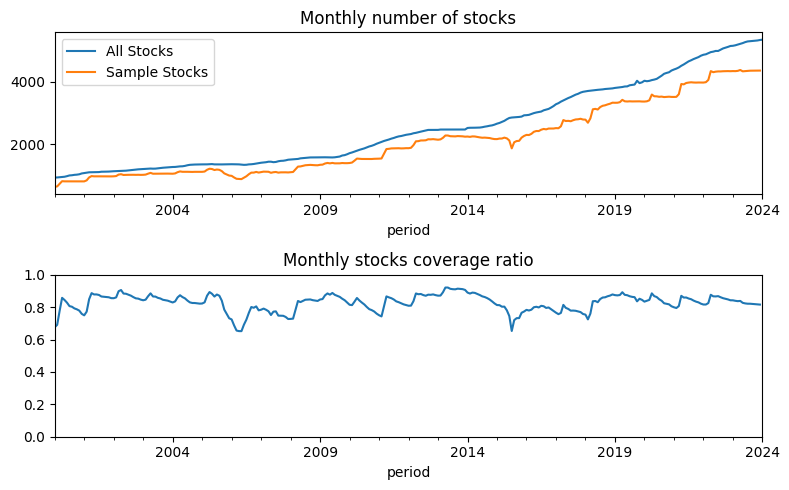

In [49]:
#查看样本股票的覆盖度
#股票月度数据量
price_data = pd.read_csv(f'{path}/price_data.csv',usecols=[1,2])
def get_sample_coverage(sample,all,sample_stkcd='WINDCODE',sample_date='period',all_date='TRADE_DT',all_stkcd='S_INFO_WINDCODE',
                        period_type='M',datetime_format='%Y%m%d',cut_on='19990101',cut_off='20240101'):
    #上限时间与下限时间范围
    cut_off = pd.Period(cut_off,freq = period_type)
    cut_on = pd.Period(cut_on,freq = period_type)
    #股票原始数据
    all[sample_date] = pd.to_datetime(all[all_date],format=datetime_format).dt.to_period(period_type)
    monthly_nstocks = all.groupby(all[sample_date])[all_stkcd].nunique()
    monthly_nstocks = monthly_nstocks[(monthly_nstocks.index >= cut_on) & (monthly_nstocks.index <= cut_off)]
    plt.figure(figsize=(8, 5))
    plt.subplot(2,1,1)
    monthly_nstocks.plot(label='All Stocks')
    #样本股票数据
    monthly_unique_data = sample.groupby(sample_date)[sample_stkcd].nunique()
    monthly_unique_data = monthly_unique_data[(monthly_unique_data.index >= cut_on) & (monthly_unique_data.index <= cut_off)]
    monthly_unique_data.plot(label='Sample Stocks')
    plt.legend()
    plt.title('Monthly number of stocks')
    plt.subplot(2,1,2)
    #样本股票覆盖率
    unique_ratio = monthly_unique_data/monthly_nstocks
    unique_ratio.plot()
    plt.ylim(0,1)
    plt.title('Monthly stocks coverage ratio')
    plt.tight_layout()
    #返回覆盖率数据，可以具体分析
    return unique_ratio
monthly_coveragee = get_sample_coverage(sample=monthly_stocks_2,all=price_data,cut_on='20000101')
del price_data
monthly_coveragee.mean()

monthly_stocks_2.to_csv(f'{path}/导出/monthly_stocks.csv',index=False)

# 五因子构建

### 1.五因子计算

In [50]:
#五因子计算函数
def get_label(df, f1, f1_label, date, f1_group, **kwargs):
    if f1_group == 3 and kwargs.get('method', None) == 'classical':
        df[f1_label] = 2
        # 确保使用 loc 进行赋值，并且正确处理分组
        quantile_70 = df.groupby(date)[f1].transform(lambda x: x >= x.quantile(0.7))
        quantile_30 = df.groupby(date)[f1].transform(lambda x: x <= x.quantile(0.3))
        df.loc[quantile_70, f1_label] = 3
        df.loc[quantile_30, f1_label] = 1
    else:
        # 确保 rank 方法使用正确，并且正确处理分组
        df[f1_label] = df.groupby(date, group_keys=False)[f1].apply(
            lambda x: np.ceil(x.rank() / (len(x) / f1_group))
        )
    # 确保字符串格式化正确
    df[f1_label] = f1_label + df[f1_label].astype(str)
    return df
def fama_french_five_factor(
        df, size, value, profit, invest, ret, date, size_group=2, value_group=3, profit_group=3, invest_group=3,
        ret_type='mkt', **kwargs
):
    """
    根据给定的数据源和因子列名生成此数据的五因子序列
    Args:
        df: 数据源
        size: 总市值列名
        value: 账面市值比列名
        profit: 盈利变量列名
        invest: 投资变量列名
        ret: 收益率列名
        date: 日期列名
        size_group: 规模因子分组数
        value_group: 价值因子分组数
        profit_group: 盈利因子分组数
        invest_group: 投资因子分组数
        ret_type: 组合内股票加权方式，mkt:市值加权, equal:等权重
        **kwargs: 需给定method参数，classical即为经典2 * 3分组模式

    Returns: 五因子的收益时间序列，市场因子未减去无风险利率

    """
    if kwargs['method'] not in ['classical', 'simple']:
        raise ValueError("Parameter 'method' is not in ['classical', 'simple']")

    if kwargs['method'] == 'classical' and (size_group != 2 or value_group != 3 or profit_group !=3 or invest_group != 3):
        raise ValueError("Please Check Parameter group, This is not classical method")

    # 为每个因子进行独立分组
    size_label = size + '_G'
    value_label = value + '_G'
    profit_label = profit + '_G'
    invest_label = invest + '_G'
    df = get_label(df, f1=size, f1_label=size_label, date=date, f1_group=size_group, **kwargs)
    df = get_label(df, f1=value, f1_label=value_label, date=date, f1_group=value_group, **kwargs)
    df = get_label(df, f1=profit, f1_label=profit_label, date=date, f1_group=profit_group, **kwargs)
    df = get_label(df, f1=invest, f1_label=invest_label, date=date, f1_group=invest_group, **kwargs)

    # 计算18个组合的加权收益率
    factor_lst = []
    for double_label, label in zip(['value_double', 'profit_double', 'invest_double'],
                                   [value_label, profit_label, invest_label]):
        df[double_label] = df[[size_label, label]].apply(
            lambda x: x[size_label] + '/' + x[label], axis=1
        )
        if ret_type == 'mkt':
            ret_series = df.groupby([date, double_label]).apply(
                lambda x: (x[ret] * x[size] / x[size].sum()).sum()
            ).unstack(double_label)
        elif ret_type == 'equal':
            ret_series = df.groupby([date, double_label]).apply(
                lambda x: x[ret].mean()
            ).unstack(double_label)
        else:
            raise ValueError("Parameter 'ret_type' is not in ['mkt', 'equal']")
        factor_lst.append(ret_series)
    factor_ret = pd.concat(factor_lst, axis=1)
    factor_ret.fillna(0, inplace=True)
    factor_ret.reset_index(inplace=True)
    factor_ret[date] = factor_ret[date]
    factor_ret.dropna(inplace=True)
    factor_ret.set_index([date], inplace=True)
    
    # 计算价值因子
    long_hml = [c for c in factor_ret.columns if (value_label+str(int(value_group)) in c) and (size_label in c)]
    short_hml = [c for c in factor_ret.columns if (value_label + str(1) in c) and (size_label in c)]
    factor_ret['HML'] = factor_ret[long_hml].mean(axis=1) - factor_ret[short_hml].mean(axis=1)

    # 计算盈利因子
    long_rmw = [c for c in factor_ret.columns if (profit_label+str(int(profit_group)) in c) and (size_label in c)]
    short_rmw = [c for c in factor_ret.columns if (profit_label+str(1) in c) and (size_label in c)]
    factor_ret['RMW'] = factor_ret[long_rmw].mean(axis=1) - factor_ret[short_rmw].mean(axis=1)

    # 计算投资因子
    long_cma = [c for c in factor_ret.columns if (invest_label+str(1) in c) and (size_label in c)]
    short_cma = [c for c in factor_ret.columns if (invest_label+str(int(invest_group)) in c) and (size_label in c)]
    factor_ret['CMA'] = factor_ret[long_cma].mean(axis=1) - factor_ret[short_cma].mean(axis=1)

    # 计算规模因子
    flag = True
    for other_label in [value_label, profit_label, invest_label]:
        long_smb = [c for c in factor_ret.columns if (size_label+str(1) in c) and (other_label in c)]
        short_smb = [c for c in factor_ret.columns if (size_label+str(int(size_group)) in c) and (other_label in c)]
        tmp_smb = factor_ret[long_smb].mean(axis=1) - factor_ret[short_smb].mean(axis=1)
        if flag:
            smb = tmp_smb.copy()
            flag = False
            continue
        smb = smb + tmp_smb
    smb = smb / 3
    factor_ret['SMB'] = smb

    # 计算市场因子
    mkt = df.groupby(date).apply(lambda x: (x[ret] * x[size] / x[size].sum()).sum())
    mkt.rename('MARKET', inplace=True)
    factor_ret = pd.concat([mkt, factor_ret], axis=1)
    #factor_ret['MARKET'] = factor_ret['MARKET'].shift(1)

    return factor_ret[['MARKET','SMB', 'HML', 'RMW', 'CMA']]

In [70]:
#计算五因子,此处用 euqal 和 mkt 方法计算出的检验结果有很大差异
five_factors =fama_french_five_factor(df=monthly_stocks_2.copy(), size = '流通市值', value = 'BP', 
                        profit = 'roe', invest = '总资产增长率', ret = 'pct_change', 
                        date= 'period', size_group=2, value_group=3, profit_group=3, invest_group=3,
                        ret_type='equal',method='classical')

### 2.处理无风险利率及调整风险溢价，把wind全A数据作为市场风险溢价

In [71]:
#无风险利率读取与预处理
rf_rate = pd.read_csv('/Users/hmt/Documents/ PHBS/courses/investment'
                      '/project/data/无风险利率文件135821314(仅供北京大学使用)/TRD_Nrrate.csv',usecols=[1,5])
rf_rate['Clsdt'] = pd.to_datetime(rf_rate['Clsdt'])
rf_rate['period'] = rf_rate['Clsdt'].dt.to_period('M')
rf_rate.sort_values(by=['Clsdt'],inplace=True)
rf_rate_monthly = rf_rate.groupby('period').agg({'Nrrmtdt':'first'})
cutoff_up = pd.Period(20231231,freq='M')
cutoff_down =pd.Period(20000101,freq='M')
rf_rate_monthly = rf_rate_monthly[(rf_rate_monthly.index>=cutoff_down)&(rf_rate_monthly.index<=cutoff_up)]
rf_rate_monthly.rename(columns={'Nrrmtdt':'rf_rate'},inplace=True)
rf_rate_monthly['rf_rate'] = rf_rate_monthly['rf_rate']/100

In [72]:
#调整市场组合的收益率（市场风险溢价）
five_factors['MARKET'] = five_factors['MARKET']-rf_rate_monthly['rf_rate']

In [73]:
#导入做为对比的 WIND 全 A 市场指数净值时序图
windAshare = pd.read_csv(f'{path}/windAshare.csv',usecols=[1,2,4,5,6,7,8,9,10,11,12])
windAshare['TRADE_DT'] = pd.to_datetime(windAshare['TRADE_DT'],format='%Y%m%d')
#股价行情时间裁剪，选取 20000101 到 20240101
cutoff_date_up = pd.to_datetime('20240101')
cutoff_date_down = pd.to_datetime('20000101')
# 使用布尔索引来选择date小于或等于20240101的行
windAshare = windAshare[windAshare['TRADE_DT'] <= cutoff_date_up]
windAshare = windAshare[windAshare['TRADE_DT'] >= cutoff_date_down]

#计算WIND市场系数
windAshare['period'] = windAshare['TRADE_DT'].dt.to_period('M')
windAshare_monthly = windAshare.groupby(['period']).agg({'S_DQ_PRECLOSE':'first','S_DQ_CLOSE':'last'})
windAshare_monthly['MARKET']=(windAshare_monthly['S_DQ_CLOSE']/windAshare_monthly['S_DQ_PRECLOSE']-1)
windAshare_monthly.drop(['S_DQ_PRECLOSE','S_DQ_CLOSE'],axis=1,inplace=True)
windAshare_monthly['MARKET'] = windAshare_monthly['MARKET'] - rf_rate_monthly['rf_rate']
df_wind = windAshare_monthly.copy()
df_wind.index = df_wind.index.to_timestamp()

In [74]:
#用wind全A作为市场指数的五因子数据
wind_f5 = five_factors.copy()
wind_f5['MARKET'] = windAshare_monthly['MARKET']

### 3.画出五因子净值变化图

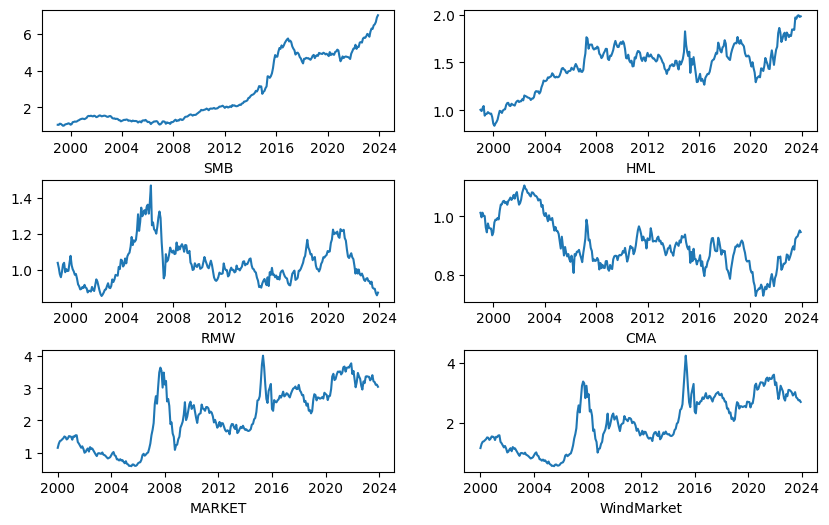

In [75]:
#画出五因子净值时间序列图
df_factor = five_factors.copy()
df_factor.index = df_factor.index.to_timestamp()  # 转换 PeriodDtype 到 datetime64
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(3,2,1)
ax1.plot((df_factor['SMB']+1).cumprod())
ax1.set_xlabel('SMB')
ax2 = fig.add_subplot(3,2,2)
ax2.plot((df_factor['HML']+1).cumprod())
ax2.set_xlabel('HML')
ax3 = fig.add_subplot(3,2,3)
ax3.plot((df_factor['RMW']+1).cumprod())
ax3.set_xlabel('RMW')
ax4 = fig.add_subplot(3,2,4)
ax4.plot((df_factor['CMA']+1).cumprod())
ax4.set_xlabel('CMA')
ax5 = fig.add_subplot(3,2,5)
ax5.plot((df_factor['MARKET']+1).cumprod())
ax5.set_xlabel('MARKET')
ax6 = fig.add_subplot(3,2,6)
ax6.plot((df_wind['MARKET']+1).cumprod())
ax6.set_xlabel('WindMarket')
plt.subplots_adjust(wspace=0.2,hspace=0.4)
plt.show()

### 4.画出 CSMAR 计算的五因子净值变化图

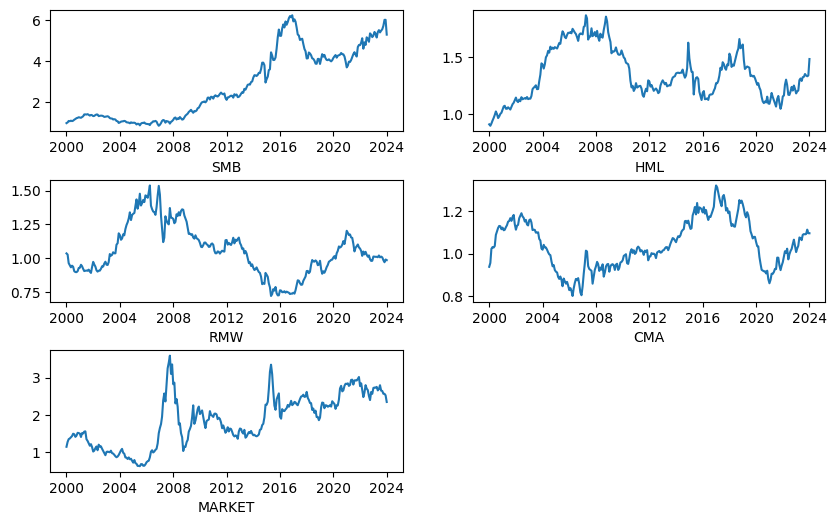

In [76]:
#读取CSMAR的五因子也跑一下试试
test = pd.read_csv('/Users/hmt/Documents/ PHBS/courses/investment/project/data/五因子模型指标(月)153236296(仅供北京大学使用)/STK_MKT_FIVEFACMONTH.csv')

condition = ((test['MarkettypeID']=='P9709')&(test['Portfolios']==1))
test = test[condition]
#市值加权
csmar_f5 = test[['TradingMonth', 'RiskPremium1','SMB1', 'HML1', 'RMW1', 'CMA1']].copy()
csmar_f5.rename(columns={'TradingMonth':'period','RiskPremium1':'MARKET','SMB1':'SMB', 
                         'HML1':'HML', 'RMW1':'RMW','CMA1':'CMA'},inplace=True)
#等权重加权，与市值加权结果差不多
#csmar_f5 = test[['TradingMonth', 'RiskPremium2','SMB2', 'HML2', 'RMW2', 'CMA2']].copy()
#csmar_f5.rename(columns={'TradingMonth':'period','RiskPremium2':'MARKET','SMB2':'SMB', 
#                         'HML2':'HML', 'RMW2':'RMW','CMA2':'CMA'},inplace=True)

csmar_f5['period'] = pd.to_datetime(csmar_f5['period'])
csmar_f5['period'] = csmar_f5['period'].dt.to_period(freq='M')
csmar_f5.set_index('period',inplace=True)

#画出五因子净值时间序列图
df_factor = csmar_f5.copy()
df_factor.index = df_factor.index.to_timestamp()  # 转换 PeriodDtype 到 datetime64
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(3,2,1)
ax1.plot((df_factor['SMB']+1).cumprod())
ax1.set_xlabel('SMB')
ax2 = fig.add_subplot(3,2,2)
ax2.plot((df_factor['HML']+1).cumprod())
ax2.set_xlabel('HML')
ax3 = fig.add_subplot(3,2,3)
ax3.plot((df_factor['RMW']+1).cumprod())
ax3.set_xlabel('RMW')
ax4 = fig.add_subplot(3,2,4)
ax4.plot((df_factor['CMA']+1).cumprod())
ax4.set_xlabel('CMA')
ax5 = fig.add_subplot(3,2,5)
ax5.plot((df_factor['MARKET']+1).cumprod())
ax5.set_xlabel('MARKET')
plt.subplots_adjust(wspace=0.2,hspace=0.4)
plt.show()

### 5.时间序列统计特征：t均值检验，相关系数，描述性统计

In [77]:
#时间序列t检验函数
def newy_west_test(data, **kwargs):
    mean_test = []
    data = data.copy().dropna()#此列删除了空值，注意时间尺度的统一
    for column in data.columns:
        model = sm.OLS(data[column], np.ones(len(data[column])))
        result = model.fit(missing='drop', cov_type='HAC', cov_kwds={'maxlags': 5})
        mean_test.append([column, list(result.params)[0], list(result.tvalues)[0], list(result.pvalues)[0]])

    mean = "Ret_mean(%)"
    mean_test = pd.DataFrame(mean_test, columns=['factor', mean, 'T_value', 'P_value'])
    mean_test[mean] = mean_test[mean] * 100
    mean_test['P_star'] = mean_test.apply(
        lambda x:
        "***" if x['P_value'] <= 0.01 else
        ("**" if x['P_value'] <= 0.05
         else ("*" if x['P_value'] <= 0.1
               else "")), axis=1
    )
    return mean_test

In [78]:
#时间序列 t 检验
mean_test1 = newy_west_test(five_factors)
mean_test2 = newy_west_test(wind_f5)
mean_test3 = newy_west_test(csmar_f5)
print(mean_test1)
print(mean_test2)
print(mean_test3)

   factor  Ret_mean(%)   T_value   P_value P_star
0  MARKET     0.675329  1.187156  0.235166       
1     SMB     0.689110  3.457133  0.000546    ***
2     HML     0.311900  1.803435  0.071320      *
3     RMW    -0.017511 -0.109176  0.913063       
4     CMA     0.026649  0.226446  0.820855       
   factor  Ret_mean(%)   T_value   P_value P_star
0  MARKET     0.650424  1.132198  0.257551       
1     SMB     0.689110  3.457133  0.000546    ***
2     HML     0.311900  1.803435  0.071320      *
3     RMW    -0.017511 -0.109176  0.913063       
4     CMA     0.026649  0.226446  0.820855       
   factor  Ret_mean(%)   T_value   P_value P_star
0  MARKET     0.564680  1.046836  0.295175       
1     SMB     0.682343  2.627971  0.008590    ***
2     HML     0.191597  1.055835  0.291044       
3     RMW     0.038709  0.234300  0.814752       
4     CMA     0.057817  0.424811  0.670974       


In [79]:
#计算五因子的相关系数
correlation_matrix1 = five_factors.corr(method='spearman')
correlation_matrix2 = wind_f5.corr(method='spearman')
correlation_matrix3 = csmar_f5.corr(method='spearman')

print(correlation_matrix1)
print(correlation_matrix2)
print(correlation_matrix3)

          MARKET       SMB       HML       RMW       CMA
MARKET  1.000000  0.104580  0.050144 -0.263662  0.092568
SMB     0.104580  1.000000 -0.136160 -0.423207  0.251922
HML     0.050144 -0.136160  1.000000 -0.354686  0.558375
RMW    -0.263662 -0.423207 -0.354686  1.000000 -0.808079
CMA     0.092568  0.251922  0.558375 -0.808079  1.000000
          MARKET       SMB       HML       RMW       CMA
MARKET  1.000000  0.148849 -0.002592 -0.265673  0.063462
SMB     0.148849  1.000000 -0.136160 -0.423207  0.251922
HML    -0.002592 -0.136160  1.000000 -0.354686  0.558375
RMW    -0.265673 -0.423207 -0.354686  1.000000 -0.808079
CMA     0.063462  0.251922  0.558375 -0.808079  1.000000
          MARKET       SMB       HML       RMW       CMA
MARKET  1.000000  0.180797 -0.169214 -0.304056  0.095029
SMB     0.180797  1.000000 -0.451227 -0.728686  0.411342
HML    -0.169214 -0.451227  1.000000  0.209346  0.173480
RMW    -0.304056 -0.728686  0.209346  1.000000 -0.639888
CMA     0.095029  0.411342  0.1

In [80]:
#描述性统计
describes1 = five_factors.describe()
describes2 = wind_f5.describe()
describes3 = csmar_f5.describe()
print(describes1)
print(describes2)
print(describes3)

           MARKET         SMB         HML         RMW         CMA
count  288.000000  300.000000  300.000000  300.000000  300.000000
mean     0.006753    0.007024    0.002777   -0.000029    0.000038
std      0.075866    0.032333    0.031581    0.029240    0.021225
min     -0.268297   -0.127652   -0.136664   -0.151348   -0.062349
25%     -0.039211   -0.012187   -0.012035   -0.017581   -0.013831
50%      0.006447    0.007776    0.000959    0.000299    0.000148
75%      0.042369    0.025071    0.021286    0.015629    0.012887
max      0.303763    0.175586    0.133087    0.122123    0.079322
           MARKET         SMB         HML         RMW         CMA
count  288.000000  300.000000  300.000000  300.000000  300.000000
mean     0.006504    0.007024    0.002777   -0.000029    0.000038
std      0.078030    0.032333    0.031581    0.029240    0.021225
min     -0.276813   -0.127652   -0.136664   -0.151348   -0.062349
25%     -0.039319   -0.012187   -0.012035   -0.017581   -0.013831
50%      0

# 单因子检验（暂时不用）

In [81]:
def gen_value_data(df):
    """
    市值取对数，计算重构的价值因子
    :param df: monthly_data
    :return: 含有重构的价值的数据
    """
    df['BM1'] = 1 / df['pb']
    df['BM2'] = df['book_value'] / df['mkt']
    df['EP'] = 1 / df['pe']
    df['FCF2M'] = df['FCF'] / df['mkt']
    df['Revenue2M'] = df['revenue'] / df['mkt']
    df['RE2M'] = df['Retained_Earnings'] / df['mkt']
    df['CC2M'] = df['Contributed_Capital'] / df['mkt']

    # 取对数计算
    df.rename(columns={'mkt': 'ori_mkt'}, inplace=True)
    df['mkt'] = np.log(df['ori_mkt'])
    return df

def winsorize(s):
    up_q = s.quantile(0.99)
    low_q = s.quantile(0.01)
    s = np.where(s > up_q, up_q, s)
    s = np.where(s < low_q, low_q, s)
    upper = s.mean() + s.std() * 3
    low = s.mean() - s.std() * 3
    s = np.where(s > upper, upper, s)
    s = np.where(s < low, low, s)
    return s

def newy_west_test(data, factor, **kwargs):
    mean_test = []
    for column in data.columns:
        model = sm.OLS(data[column], np.ones(len(data[column])))
        result = model.fit(missing='drop', cov_type='HAC', cov_kwds={'maxlags': 5})
        mean_test.append([column, list(result.params)[0], list(result.tvalues)[0], list(result.pvalues)[0]])

    mean = "Ret_mean(%)"
    mean_test = pd.DataFrame(mean_test, columns=[factor, mean, 'T_value', 'P_value'])
    mean_test[mean] = mean_test[mean] * 100
    mean_test['P_star'] = mean_test.apply(
        lambda x:
        "***" if x['P_value'] <= 0.01 else
        ("**" if x['P_value'] <= 0.05
         else ("*" if x['P_value'] <= 0.1
               else "")), axis=1
    )
    return mean_test

def construct_single_factor_return(df, sort_factor, date, ret, ori_mkt, **kwargs):
    df = df.copy()
    # rank 越小排前面
    group_label = sort_factor + '_G'
    # FCF还有缺失，用均值填充一下
    df[group_label] = df.groupby(date, group_keys=False)[sort_factor].apply(
        lambda x: np.ceil(x.rank() / (len(x) / kwargs["groups"]))
    )
    if kwargs["ret_type"] == 'mkt':
        ret_label = sort_factor + '_mkt_ret'
        factor_ret = df.groupby([date, group_label], as_index=False).apply(
            lambda x: (x[ret] * x[ori_mkt] / x[ori_mkt].sum()).sum()
        )
    else:
        ret_label = sort_factor + '_mean_ret'
        factor_ret = df.groupby([date, group_label], as_index=False).apply(
            lambda x: x[ret].mean()
        )
    factor_ret.rename(columns={factor_ret.columns[-1]: ret_label}, inplace=True)
    factor_ret.sort_values(by=[group_label, date], inplace=True)
    factor_ret[ret_label] = factor_ret.groupby(group_label)[ret_label].shift(1)
    factor_ret.set_index([date, group_label], inplace=True)
    return df, factor_ret.dropna()


def output_single_test(m_data, value_column, date, ret, ori_mkt, **kwargs):
    data, bm_factor = construct_single_factor_return(
        m_data, value_column, date, ret, ori_mkt, **kwargs
    )
    bm_factor_series = bm_factor.unstack(value_column + '_G').droplevel(level=0, axis=1)  # 去除multi columns
    bm_factor_series.fillna(0, inplace=True)
    bm_factor_series['long_short'] = bm_factor_series[10.0] - bm_factor_series[1.0]

    res = newy_west_test(bm_factor_series, value_column, **kwargs)
    if not os.path.exists(f"结果/{kwargs['save_path']}/"):
        os.makedirs(f"结果/{kwargs['save_path']}/")
    res.to_csv(
        f"结果/{kwargs['save_path']}/{value_column}_{kwargs['ret_type']}_single_test.csv", index=False
    )
    return res

def single_factor_summary(single_factors, ret_types, path, save=True):
    all_test = pd.DataFrame()
    for factor in single_factors:
        one_test = pd.DataFrame()
        for ret_type in ret_types:
            t_data = pd.read_csv(path + f"{factor}_{ret_type}_single_test.csv")
            t_data['Group'] = [str(i) for i in range(1, 10)] + ['High', '多空组合']
            t_data['Ret_mean(%)'] = t_data['Ret_mean(%)'].apply(lambda x: format(x, '.2f'))
            t_data['Ret_mean(%)'] = t_data['Ret_mean(%)'].astype(str)
            t_data['P_star'] = t_data['P_star'].replace(np.NAN, "")
            t_data['Ret_mean(%)'] = t_data.apply(
                lambda x: x['Ret_mean(%)'] + x['P_star'], axis=1
            )
            t_data['T_value'] = t_data['T_value'].apply(lambda x: "(" + format(x, '.2f') + ")")
            t_value = t_data[['Group', 'T_value']].rename(columns={'T_value': f'{ret_type}_test'})
            t_value['Group'] = [str(i + 0.5) for i in range(1, 10)] + ['High2', '多空组合2']
            res = pd.concat([t_data[['Group', 'Ret_mean(%)']].rename(columns={'Ret_mean(%)': f'{ret_type}_test'}),
                             t_value]).sort_values(by='Group')
            res.rename(columns={'Group': '分组'}, inplace=True)
            res.set_index(['分组'], inplace=True)
            if one_test.empty:
                one_test = res
            else:
                one_test = pd.concat([one_test, res], axis=1)
                one_test.columns = ['等权重', '市值加权']

        one_test = pd.DataFrame(one_test.values, columns=[[factor] * 2, list(one_test.columns)],
                                index=[['Low'] * 2 + sorted([str(i) for i in range(2, 10)] * 2)
                                       + sorted(['High', '多空组合'] * 2),
                                       list(one_test.index)])
        if all_test.empty:
            all_test = one_test.copy()
        else:
            all_test = pd.concat([all_test, one_test], axis=1)
    all_test = all_test.droplevel(level=-1)
    all_test.index.name = '分组'
    if save:
        all_test.to_excel(path + '检验结果汇总.xlsx')
    return all_test

In [82]:
if __name__ == "__main__":
    mid_path = '/Users/hmt/Documents/ PHBS/courses/investment/project/data/wind底层库数据/导出/'
    fig_path = '/Users/hmt/Documents/ PHBS/courses/investment/project/data/wind底层库数据/导出/单因子检验'
    monthly_data = pd.read_csv(mid_path + 'monthly_stocks.csv')
    # 生成因子原始值，我使用的数据已经生成
    # 缩尾
    for c in ['BP', 'roe','流通市值','总资产增长率']:
        monthly_data[c] = winsorize(monthly_data[c])
        
    factors = ['BP', 'roe','流通市值','总资产增长率']
    types = ['equal', 'mkt']
    for c in factors:
        for ret_type in types:
            output_single_test(
                monthly_data, groups=10, value_column=c, date='period' , 
                ret='pct_change', ori_mkt='流通市值', ret_type=ret_type, save_path='价值因子单因子检验'
            )
    single_factor_summary(factors, types, path="结果/价值因子单因子检验/",save=True)

# 因变量构建

In [83]:
def independent_double_sort(df,groups=5, stkcd='WINDCODE',date='period',
                            factor1='流通市值',factor2='BP',time_up='2024-01',time_down='2000-01',freq_type='M'):
    
    f_5 = df[[stkcd,date,factor1,factor2]].copy()
    
    f_5 = f_5[f_5[date]>=pd.Period(time_down,freq=freq_type)]
    f_5 = f_5[f_5[date]<=pd.Period(time_up,freq=freq_type)]
    f_5['g_'+factor2]=f_5.groupby(date)[factor2].transform(lambda x: np.ceil(x.rank()/(len(x)/groups)).astype(int))
    f_5['g_'+factor1]=f_5.groupby(date)[factor1].transform(lambda x: np.ceil(x.rank()/(len(x)/groups)).astype(int))
    f_5=f_5[[stkcd,date,'g_'+factor1,'g_'+factor2]]
    
    return pd.merge(df,f_5,on=[stkcd,date],how='right').reset_index(drop=True)

def cacaculate_double_sort_ret(df,groups=5,stkcd='WINDCODE',date='period',
                               ret='pct_change',factor1='流通市值',factor2='BP',
                               time_up='2024-01',time_down='2000-01'):
    port25_ret = independent_double_sort(df,groups,stkcd,
                                         date,factor1,factor2,time_up,time_down).groupby(['g_'+factor1,
                                                                        'g_'+factor2]).apply(lambda x:(x[ret]*100).mean()).reset_index()
    port25_ret.rename(columns={port25_ret.columns[-1]:'pct_change_mean'},inplace=True)
    port25_ret_pivot=port25_ret.pivot(index='g_'+factor1,columns='g_'+factor2,values='pct_change_mean')
    port25_ret_pivot.index.name=None
    port25_ret_pivot.columns.name=None
    port25_ret_pivot.rename(index={port25_ret_pivot.index[0]:'Small '+factor1,port25_ret_pivot.index[-1]:'Big '+factor1},
                            columns={port25_ret_pivot.columns[0]:'Small '+factor2,port25_ret_pivot.columns[-1]:'Big '+factor2},
                            inplace=True)
    return port25_ret_pivot.head()


In [84]:
#调用分组透视输出分析数据
port25_ret_pivot = cacaculate_double_sort_ret(monthly_stocks_2,factor2='BP',time_up='2024-01',time_down='2000-01')
port25_ret_pivot

,Small BP,2,3,4,Big BP
Small 流通市值,1.192117,1.564116,1.925427,2.129569,2.711704
2,0.848709,1.301858,1.338126,1.531851,1.669678
3,0.493359,0.844061,0.900648,0.955293,0.924339
4,0.495295,0.807551,0.744828,0.757061,0.756134
Big 流通市值,0.526551,0.560641,0.558357,0.610241,0.637216


# 因子模型回归分析

### 1.五因子模型

In [85]:
def GRS(alpha, resids, factor):
    # GRS test statistic
    # N个待检验资产组合, L个因子, and T 时间周期
    # alpha是定价误差，Nx1的数组
    # resids回归的残差，TxN的数组
    # factor是因子收益率，TxL的数组
    T, N = resids.shape
    L = factor.shape[1]
    factor_mean = np.nanmean(factor, axis=0)
    cov_resids = np.matmul(resids.T, resids) / (T-L-1)
    cov_fac = np.matmul(np.array(factor - np.nanmean(factor, axis=0)).T, np.array(factor - np.nanmean(factor, axis=0))) / T-1
    GRS = (T / N) * ((T - N - L) / (T - L - 1)) * ((np.matmul(np.matmul(alpha.T, inv(cov_resids)), alpha)) / (1 + (np.matmul(np.matmul(factor_mean.T, inv(cov_fac)), factor_mean))))
    pVal = 1 - scipy.stats.f.cdf(GRS, N, T - N - L) #需引用F分布“scipy.stats.f”
    return GRS, pVal

# FF5因子回归
def FF5_regression(df,df_f5,df_rf,groups=5,stkcd='WINDCODE',date='period',factor1='流通市值',factor2='BP',
                   ret='pct_change',mv='流通市值',time_up='2024-01',time_down='2000-01',freq_type='M'):
    ds_stocks = independent_double_sort(df,groups,stkcd,date,factor1,factor2,time_up,time_down,freq_type)
    ds_stocks['group']=ds_stocks.apply(lambda x:factor2+str(int(x['g_'+factor2]))+
                                       '-'+factor1+str(int(x['g_'+factor1])),axis=1)
    f25=ds_stocks.groupby([date,'group']).apply(lambda x: (x[ret]*x[mv]).sum()/x[mv].sum())
    f25=f25.unstack()
    f25=pd.merge(f25,df_f5,how='inner',left_index=True,right_index=True)
    f25=pd.merge(f25,df_rf,how='inner',left_index=True,right_index=True)
    f25['Intercept']=1
    
    #FF5
    x=f25.loc[:,['MARKET','SMB','HML','RMW','CMA','Intercept','rf_rate']]
    x.fillna(0,inplace=True)
    r2=[]
    betas=[]
    t=[]
    p=[]
    resid_list=[]
    for i in range(25):
        y=f25.loc[:,f25.columns[i]]
        mod=sm.OLS(y-x['rf_rate'],x[['MARKET','SMB','HML','RMW','CMA','Intercept']]).fit()
        
        resid_list.append(mod.resid.values)
        r2.append([f25.columns[i],mod.rsquared])
        betas.append([f25.columns[i]]+list(mod.params))
        t.append([f25.columns[i]]+list(mod.tvalues))
        p.append([f25.columns[i]]+list(mod.pvalues))

    p=pd.DataFrame(p,columns=['group','MARKET','SMB','HML','RMW','CMA','Intercept'])
    t=pd.DataFrame(t,columns=['group','MARKET','SMB','HML','RMW','CMA','Intercept'])
    betas=pd.DataFrame(betas,columns=['group','MARKET','SMB','HML','RMW','CMA','Intercept'])
    r2=pd.DataFrame(r2,columns=['group','r2'])

    resid_array = np.concatenate(resid_list).reshape(-1,groups*groups)
    alpha_array = betas['Intercept'].to_numpy().reshape(-1,1)
    factor_array = f25[['MARKET','SMB','HML','RMW','CMA']].to_numpy()
    grs,Pgrs = GRS(alpha_array,resid_array,factor_array)
    print(f'GRS检验结果:{grs[0][0]:.4f},p值(pGRS):{Pgrs[0][0]*100:.2f}%') #GRS检验
    return p,t,betas,r2

In [127]:
#模型调用，计算五因子模型，此处用的 wind_f5,因为实验后效果更好，可能是剔除股票的原因把
p,t,betas,r2 = FF5_regression(df = monthly_stocks_2,
                              df_f5 =  wind_f5, df_rf = rf_rate_monthly,
                              factor1='流通市值',factor2='roe',time_up='2023-12',time_down='2000-01')

GRS检验结果:3.7326,p值(pGRS):0.00%


In [128]:
#解释效力
#t.style.applymap(lambda x: 'color: red' if abs(x) >=2 else 'color:None',subset='Intercept')
t[t['Intercept'].abs()>=2].count()

group        6
MARKET       6
SMB          6
HML          6
RMW          6
CMA          6
Intercept    6
dtype: int64

In [129]:
print(abs(betas['Intercept']).mean())
print(abs(r2['r2']).mean())
print(abs(t['Intercept']).mean())

0.002188279945418255
0.9319582636806798
1.4977783717449977


In [130]:
#模型调用,csmar因子
p,t,betas,r2 = FF5_regression(df = monthly_stocks_2,
                              df_f5 = csmar_f5, df_rf = rf_rate_monthly,
                              factor1='流通市值',factor2='roe',time_up='2023-12',time_down='2000-01')

GRS检验结果:3.9228,p值(pGRS):0.00%


In [131]:
print(abs(betas['Intercept']).mean())
print(abs(r2['r2']).mean())
print(abs(t['Intercept']).mean())

0.0025400548648633016
0.9250589819660914
1.652675752343013


In [132]:
t.style.applymap(lambda x: 'color: red' if abs(x) >=2 else 'color:None',subset='Intercept')
t[t['Intercept'].abs()>=2].count()

group        8
MARKET       8
SMB          8
HML          8
RMW          8
CMA          8
Intercept    8
dtype: int64

### 2.CAPM模型

In [92]:
# CAPM回归
def CAPM_regression(df,df_f5,df_rf,groups=5,stkcd='WINDCODE',date='period',factor1='流通市值',factor2='BP',
                   ret='pct_change',mv='流通市值',time_up='2024-01',time_down='2000-01',freq_type='M'):
    ds_stocks = independent_double_sort(df,groups,stkcd,date,factor1,factor2,time_up,time_down,freq_type)
    ds_stocks['group']=ds_stocks.apply(lambda x:factor2+str(int(x['g_'+factor2]))+
                                       '-'+factor1+str(int(x['g_'+factor1])),axis=1)
    f25=ds_stocks.groupby([date,'group']).apply(lambda x: (x[ret]*x[mv]).sum()/x[mv].sum())
    f25=f25.unstack()
    f25=pd.merge(f25,df_f5,how='inner',left_index=True,right_index=True)
    f25=pd.merge(f25,df_rf,how='inner',left_index=True,right_index=True)
    f25['Intercept']=1

    #CAPM
    x=f25.loc[:,['MARKET','Intercept','rf_rate']]
    x.fillna(0,inplace=True)
    r2=[]
    betas=[]
    t=[]
    p=[]
    resid_list = []
    for i in range(25):
        y=f25.loc[:,f25.columns[i]]
        mod=sm.OLS(y-x['rf_rate'],x[['MARKET','Intercept']]).fit()
        resid_list.append(mod.resid.values)    
        r2.append([f25.columns[i],mod.rsquared])
        betas.append([f25.columns[i]]+list(mod.params))
        t.append([f25.columns[i]]+list(mod.tvalues))
        p.append([f25.columns[i]]+list(mod.pvalues))

    p=pd.DataFrame(p,columns=['group','MARKET','Intercept'])
    t=pd.DataFrame(t,columns=['group','MARKET','Intercept'])
    betas=pd.DataFrame(betas,columns=['group','MARKET','Intercept'])
    r2=pd.DataFrame(r2,columns=['group','r2'])

    resid_array = np.concatenate(resid_list).reshape(-1,groups*groups)
    alpha_array = betas['Intercept'].to_numpy().reshape(-1,1)
    factor_array = f25[['MARKET']].to_numpy()
    grs,Pgrs = GRS(alpha_array,resid_array,factor_array)
    print(f'GRS检验结果:{grs[0][0]:.4f},p值(pGRS):{Pgrs[0][0]*100:.2f}%') #GRS检验
    return p,t,betas,r2

In [93]:
#模型调用
p_capm,t_capm,betas_capm,r2_capm = CAPM_regression(df = monthly_stocks_2,
                                                   df_f5 = five_factors, df_rf = rf_rate_monthly,
                                                   factor1='流通市值',factor2='BP',time_up='2023-12',time_down='2000-01')

GRS检验结果:3.8544,p值(pGRS):0.00%


In [94]:
print(abs(betas_capm['Intercept']).mean())
print(abs(r2_capm['r2']).mean())

0.003986808040661757
0.7846306557759861


In [165]:
#模型调用,csmar因子
p_capm,t_capm,betas_capm,r2_capm = CAPM_regression(df = monthly_stocks_2,
                                                   df_f5 = csmar_f5, df_rf = rf_rate_monthly,
                                                   factor1='流通市值',factor2='BP',time_up='2023-12',time_down='2000-01')

GRS检验结果:3.8466,p值(pGRS):0.00%


In [44]:
print(abs(betas_capm['Intercept']).mean())
print(abs(r2_capm['r2']).mean())

0.004949828185165916
0.7174496064245591


### 3.任意因子回归，默认为 3 因子模型

In [95]:
# 任意因子回归模型,默认为3因子
def nfactors_regression(df,df_f5,df_rf,nfactors=['MARKET','SMB','HML','Intercept','rf_rate'],groups=5,stkcd='WINDCODE',date='period',factor1='流通市值',factor2='BP',
                   ret='pct_change',mv='流通市值',time_up='2024-01',time_down='2000-01',freq_type='M'):
    ds_stocks = independent_double_sort(df,groups,stkcd,date,factor1,factor2,time_up,time_down,freq_type)
    ds_stocks['group']=ds_stocks.apply(lambda x:factor2+str(int(x['g_'+factor2]))+
                                       '-'+factor1+str(int(x['g_'+factor1])),axis=1)
    f25=ds_stocks.groupby([date,'group']).apply(lambda x: (x[ret]*x[mv]).sum()/x[mv].sum())
    f25=f25.unstack()
    f25=pd.merge(f25,df_f5,how='inner',left_index=True,right_index=True)
    f25=pd.merge(f25,df_rf,how='inner',left_index=True,right_index=True)
    f25['Intercept']=1
    
    #FF5
    x=f25[nfactors]
    x.fillna(0,inplace=True)
    r2=[]
    betas=[]
    t=[]
    p=[]
    resid_list=[]
    nfactors_copy = [f for f in nfactors if f != 'rf_rate']
    
    for i in range(25):
        y=f25.loc[:,f25.columns[i]]
        mod=sm.OLS(y-x['rf_rate'],x[nfactors_copy]).fit()
        resid_list.append(mod.resid.values)
        r2.append([f25.columns[i],mod.rsquared])
        betas.append([f25.columns[i]]+list(mod.params))
        t.append([f25.columns[i]]+list(mod.tvalues))
        p.append([f25.columns[i]]+list(mod.pvalues))
    

    p=pd.DataFrame(p,columns=['group'] + nfactors_copy)
    t=pd.DataFrame(t,columns=['group'] + nfactors_copy)
    betas=pd.DataFrame(betas,columns=['group'] + nfactors_copy)
    r2=pd.DataFrame(r2,columns=['group','r2'])

    resid_array = np.concatenate(resid_list).reshape(-1,groups*groups)
    alpha_array = betas['Intercept'].to_numpy().reshape(-1,1)
    nfactors_identity = [f for f in nfactors_copy if f !='Intercept']
    factor_array = f25[nfactors_identity].to_numpy()
    grs,Pgrs = GRS(alpha_array,resid_array,factor_array)
    print(f'GRS检验结果:{grs[0][0]:.4f},p值(pGRS):{Pgrs[0][0]*100:.2f}%') #GRS检验

    return p,t,betas,r2

In [96]:
#模型调用
p_3,t_3,betas_3,r2_3 = nfactors_regression(df = monthly_stocks_2,df_f5 = wind_f5, df_rf = rf_rate_monthly,
                                           nfactors=['MARKET','SMB','HML','Intercept','rf_rate'],
                                           factor1='流通市值',factor2='BP')

GRS检验结果:3.6211,p值(pGRS):0.00%


In [97]:
print(abs(betas_3['Intercept']).mean())
print(abs(r2_3['r2']).mean())

0.0022836055711684612
0.9321690025521628


In [98]:
#模型调用,csmar的三因子
p_3,t_3,betas_3,r2_3 = nfactors_regression(df = monthly_stocks_2,df_f5 = csmar_f5, df_rf = rf_rate_monthly,
                                           nfactors=['MARKET','SMB','HML','Intercept','rf_rate'],
                                           factor1='流通市值',factor2='BP')

GRS检验结果:4.9883,p值(pGRS):0.00%


In [99]:
print(abs(betas_3['Intercept']).mean())
print(abs(r2_3['r2']).mean())

0.0025726124426995976
0.926929433290369


In [100]:
#模型调用,4因子,无CMA
p_31,t_31,betas_31,r2_31 = nfactors_regression(df = monthly_stocks_2,df_f5 = wind_f5, df_rf = rf_rate_monthly,
                                           nfactors=['MARKET','SMB','HML','RMW','Intercept','rf_rate'],
                                           factor1='流通市值',factor2='BP')
print(abs(betas_31['Intercept']).mean())
print(abs(r2_31['r2']).mean())

GRS检验结果:1.8847,p值(pGRS):0.80%
0.0015650595375965217
0.9352302374125822


In [101]:
t_31[t_31['Intercept'].abs()>=2].count()

group        3
MARKET       3
SMB          3
HML          3
RMW          3
Intercept    3
dtype: int64

In [102]:
#模型调用,csmar的4因子
p_31,t_31,betas_31,r2_31 = nfactors_regression(df = monthly_stocks_2,df_f5 = csmar_f5, df_rf = rf_rate_monthly,
                                           nfactors=['MARKET','SMB','HML','RMW','Intercept','rf_rate'],
                                           factor1='流通市值',factor2='BP')
print(abs(betas_31['Intercept']).mean())
print(abs(r2_31['r2']).mean())

GRS检验结果:4.6904,p值(pGRS):0.00%
0.0022645546461008766
0.9287726537436458


In [103]:
t_31[t_31['Intercept'].abs()>=2].count()

group        6
MARKET       6
SMB          6
HML          6
RMW          6
Intercept    6
dtype: int64

In [104]:
#模型调用,4因子:无RMW
p_32,t_32,betas_32,r2_32 = nfactors_regression(df = monthly_stocks_2,df_f5 = wind_f5, df_rf = rf_rate_monthly,
                                           nfactors=['MARKET','SMB','HML','CMA','Intercept','rf_rate'],
                                           factor1='流通市值',factor2='BP')
print(abs(betas_32['Intercept']).mean())
print(abs(r2_32['r2']).mean())

GRS检验结果:2.2313,p值(pGRS):0.10%
0.0017729680271732695
0.9347351452966296


In [105]:
#模型调用,csmar的4因子
p_32,t_32,betas_32,r2_32 = nfactors_regression(df = monthly_stocks_2,df_f5 = csmar_f5, df_rf = rf_rate_monthly,
                                           nfactors=['MARKET','SMB','HML','CMA','Intercept','rf_rate'],
                                           factor1='流通市值',factor2='BP')
print(abs(betas_32['Intercept']).mean())
print(abs(r2_32['r2']).mean())

GRS检验结果:4.8854,p值(pGRS):0.00%
0.0023926289101809024
0.9287898276693595


In [106]:
#模型调用,4因子:无HML
p_33,t_33,betas_33,r2_33 = nfactors_regression(df = monthly_stocks_2,df_f5 = wind_f5, df_rf = rf_rate_monthly,
                                           nfactors=['MARKET','SMB','RMW','CMA','Intercept','rf_rate'],
                                           factor1='流通市值',factor2='BP')
print(abs(betas_33['Intercept']).mean())
print(abs(r2_33['r2']).mean())

GRS检验结果:4.3228,p值(pGRS):0.00%
0.002425090932613852
0.9233077279217955


In [107]:
#模型调用,csmar的4因子
p_33,t_33,betas_33,r2_33 = nfactors_regression(df = monthly_stocks_2,df_f5 = csmar_f5, df_rf = rf_rate_monthly,
                                           nfactors=['MARKET','SMB','RMW','CMA','Intercept','rf_rate'],
                                           factor1='流通市值',factor2='roe')
print(abs(betas_33['Intercept']).mean())
print(abs(r2_33['r2']).mean())

GRS检验结果:4.4055,p值(pGRS):0.00%
0.0026995898161538833
0.924610220669176


In [108]:
#模型调用,4因子:无SMB
p_34,t_34,betas_34,r2_34 = nfactors_regression(df = monthly_stocks_2,df_f5 = wind_f5, df_rf = rf_rate_monthly,
                                           nfactors=['MARKET','HML','RMW','CMA','Intercept','rf_rate'],
                                           factor1='流通市值',factor2='BP')
print(abs(betas_34['Intercept']).mean())
print(abs(r2_34['r2']).mean())

GRS检验结果:12.7221,p值(pGRS):0.00%
0.005611653445620196
0.8876938324762061


In [109]:
#模型调用,csmar的4因子
p_34,t_34,betas_34,r2_34 = nfactors_regression(df = monthly_stocks_2,df_f5 = csmar_f5, df_rf = rf_rate_monthly,
                                           nfactors=['MARKET','HML','RMW','CMA','Intercept','rf_rate'],
                                           factor1='流通市值',factor2='BP')
print(abs(betas_34['Intercept']).mean())
print(abs(r2_34['r2']).mean())

GRS检验结果:15.7560,p值(pGRS):0.00%
0.0060661330771997835
0.8824568931818197


### 4.解释变量互相回归

In [110]:
# 自变量交叉回归
def cross_independent_variable_regression(df_f5,nfactors=['MARKET','SMB','HML','RMW','CMA','Intercept'],
                                         time_down='2000-01',time_up='2024-01',freq_type='M'):
    
    #互相回归
    f25 = df_f5.copy()
    f25['Intercept']=1
    f25 = f25[f25.index>=pd.Period(time_down,freq=freq_type)]
    f25 = f25[f25.index<=pd.Period(time_up,freq=freq_type)]
    x=f25.loc[:,nfactors]
    x.fillna(0,inplace=True)
    r2=[]
    betas=[]
    t=[]
    p=[]
    i=0
    for col in nfactors:
        nfactors_copy = [f for f in nfactors if f != col ]    
        y=x[col]
        mod=sm.OLS(y,x[nfactors_copy]).fit()
 
        r2.append([col,mod.rsquared])
        betas.append(mod.params)
        t.append(mod.tvalues)
        p.append(mod.pvalues)
        i+=1
        if i>4:
            break
        
    p=pd.DataFrame(p)
    t=pd.DataFrame(t)
    betas=pd.DataFrame(betas)
    r2=pd.DataFrame(r2)
    r2.columns=[['因变量','R2']]
    return p,t,betas,r2


In [111]:
pc, tc, betasc, r2c =cross_independent_variable_regression(five_factors)
r2c

,因变量,R2
0,MARKET,0.170119
1,SMB,0.402592
2,HML,0.501945
3,RMW,0.793183
4,CMA,0.788386


In [112]:
pcmar, tcmar, betascmar, r2cmar =cross_independent_variable_regression(csmar_f5)
r2cmar

,因变量,R2
0,MARKET,0.127253
1,SMB,0.715719
2,HML,0.493358
3,RMW,0.755564
4,CMA,0.598422


### 5.共线性调整

In [113]:
# 调整共线性 CMAO 计算
def get_CMAO(df_f5,time_down='2000-01',time_up='2024-01',freq_type='M'):
    
    #互相回归
    f25 = df_f5.copy()
    f25['Intercept']=1
    f25 = f25[f25.index>=pd.Period(time_down,freq=freq_type)]
    f25 = f25[f25.index<=pd.Period(time_up,freq=freq_type)]
    x=f25.loc[:,['MARKET','SMB','HML','RMW','Intercept']]
    x.fillna(0,inplace=True)
    y=f25.loc[:,'CMA'] 
    r2=[]
    betas=[]
    t=[]
    p=[]
    i=0
    mod=sm.OLS(y,x).fit()
    CMA_predict = mod.predict(x)
    f25['CMA'] = f25['CMA']- CMA_predict
    return f25[['MARKET','SMB','HML','RMW','CMA']]

CMAO_f5 = get_CMAO(wind_f5)

In [118]:
#模型调用，计算五因子模型
p_cmao,t_cmao,betas_cmao,r2_cmao = FF5_regression(df = monthly_stocks_2,
                              df_f5 = CMAO_f5, df_rf = rf_rate_monthly,
                              factor1='流通市值',factor2='总资产增长率',time_down='2000-01',time_up='2023-12')

GRS检验结果:2.0475,p值(pGRS):0.30%


In [119]:
#解释效力
#t.style.applymap(lambda x: 'color: red' if abs(x) >=2 else 'color:None',subset='Intercept')
t_cmao[t_cmao['Intercept'].abs()>=2].count()

group        6
MARKET       6
SMB          6
HML          6
RMW          6
CMA          6
Intercept    6
dtype: int64

In [120]:
print(abs(betas_cmao['Intercept']).mean())
print(abs(r2_cmao['r2']).mean())

0.0015262820576650018
0.9379542951314949


# 多因子检验

In [117]:
def independent_double_sort_factor(df, sort_factor, save_fp, 
                                   groups=5, date, ret, ori_mkt, ret_type='mkt', save=True):
    group_label = sort_factor + '_G'
    size_label = 'size_G'

    df[group_label] = df.groupby(date, group_keys=False)[sort_factor].apply(
        lambda x: np.ceil(x.rank() / (len(x) / groups))
    )
    df[group_label] = df[group_label].apply(
        lambda x: group_label + str(int(x))
    )
    df[size_label] = df.groupby(date, group_keys=False)['mkt'].apply(
        lambda x: np.ceil(x.rank() / (len(x) / groups))
    )
    df[size_label] = df[size_label].apply(
        lambda x: size_label + str(int(x))
    )
    df['double_label'] = df[[size_label, group_label]].apply(
        lambda x: x[size_label] + '/' + x[group_label], axis=1
    )
    if ret_type == 'mkt':

        factor_ret = df.groupby([date, 'double_label']).apply(
            lambda x: (x[ret] * x[ori_mkt] / x[ori_mkt].sum()).sum()
        ).unstack('double_label')
    elif ret_type == 'equal':

        factor_ret = df.groupby([date, 'double_label']).apply(
            lambda x: x[ret].mean()
        ).unstack('double_label')

    factor_ret.fillna(0, inplace=True)
    factor_ret.reset_index(inplace=True)
    factor_ret[date] = factor_ret[date].shift(-1)
    factor_ret.dropna(inplace=True)
    factor_ret.set_index([date], inplace=True)
    for i in range(groups):
        i = i + 1
        factor_ret[size_label + str(i) + '/HML'] = factor_ret[size_label + str(i) + '/' + group_label + str(groups)] - \
                                                   factor_ret[
                                                       size_label + str(i) + '/' + group_label + str(1)]
        factor_ret['Average/' + group_label + str(i)] = np.sum(factor_ret[[size_label + '1/' + group_label + str(i),
                                                                           size_label + '2/' + group_label + str(i),
                                                                           size_label + '3/' + group_label + str(i),
                                                                           size_label + '4/' + group_label + str(i),
                                                                           size_label + '5/' + group_label + str(i)
                                                                           ]], axis=1) / 5

    factor_ret['Average/HML'] = np.sum(factor_ret[[size_label + '1/HML', size_label + '2/HML', size_label + '3/HML',
                                                   size_label + '4/HML', size_label + '5/HML']], axis=1) / 5

    mean_temp = pd.DataFrame(factor_ret.mean()).reset_index()
    double_ts_mean = mean_temp['double_label'].str.split('/', expand=True)
    double_ts_mean[ret] = mean_temp[0]
    double_ts_mean.columns = ['Size', sort_factor, ret]
    BM_mean = double_ts_mean.pivot(index='Size', columns=sort_factor, values=ret)

    temp_test = []
    for column in factor_ret.columns:
        model = sm.OLS(factor_ret[column], np.ones(len(factor_ret[column])))
        result = model.fit(missing='drop', cov_type='HAC', cov_kwds={'maxlags': 5})
        temp_test.append([column, list(result.tvalues)[0], list(result.pvalues)[0]])
    temp_test = pd.DataFrame(temp_test, columns=['Double1', 'T_value', 'P_value'])

    double_mean_test = temp_test['Double1'].str.split('/', expand=True)
    double_mean_test['T_value'] = temp_test['T_value']
    double_mean_test.columns = ['Size', sort_factor, 'T_value']
    BM_test = double_mean_test.pivot(index='Size', columns=sort_factor, values='T_value')
    if not os.path.exists(f"结果/{save_fp}"):
        os.makedirs(f"结果/{save_fp}")
    if save:
        BM_mean.to_csv(f"结果/{save_fp}/{sort_factor}_{ret_type}_mean.csv")
        BM_test.to_csv(f"结果/{save_fp}/{sort_factor}_{ret_type}_ttest.csv")
    return factor_ret


def plot_double_value(factor_ret, factor, ret_type, date, save=True):
    factor_ret.reset_index(inplace=True)
    factor_ret[date] = pd.to_datetime(factor_ret[date].astype(str).apply(lambda x: x+'01'))
    with plt.style.context(['science']):
        plt.figure(figsize=(20, 9))
        plt.plot(
            factor_ret[date], (factor_ret[f'Average/{factor}_G5']+1).cumprod(), linewidth=1.5,
            color='black', alpha=0.7, ls='--', label=f"Large {factor.replace('_', '')}")  # edgecolor设置边框颜色(k是黑色)
        plt.plot(
            factor_ret[date], (factor_ret[f'Average/{factor}_G1'] + 1).cumprod(), linewidth=1.5,
            color='black', alpha=0.7, ls=':', label=f"Small {factor.replace('_', '')}")
        plt.plot(
            factor_ret[date], (factor_ret['Average/HML'] + 1).cumprod(), linewidth=1.5,
            color='black', alpha=0.7, ls='-', label='HML')
        plt.xticks(fontsize=13, rotation=30)
        plt.xlabel('$Date$', fontsize=13)
        plt.ylabel('$Cumulative\ Return$', fontsize=13, rotation=90)
        plt.grid(axis='y')
        plt.legend(loc='upper left')
        if save:
            plt.savefig(f'结果/{factor}累计收益率{ret_type}.png', dpi=300)
        plt.show()


if __name__ == "__main__":
    mid_path = '数据处理中间数据\\'
    fig_path = '结果图片\\'
    monthly_data = pd.read_csv(mid_path + 'monthly_stocks.csv')
    # 生成因子原始值

    factors = ['BM2', 'Int_BM', 'EP', 'Revenue2M', 'RE2M', 'CC2M']
    types = ['equal', 'mkt']

    # 双重排序价值因子
    for c in factors:
        for ret_type in types:
            double_sort_test(
                monthly_data, sort_factor=c, save_fp='价值因子双重排序检验',
                ret_type=ret_type
            )

    double_path = "结果/价值因子双重排序检验/"
    double_factor_summary(factors, types, double_path)

    for c in ['BM2', 'Int_BM', 'EP']:
        for ret_type in ['mkt', 'equal']:
            return_series = double_sort_test(
                monthly_data, sort_factor=c, save_fp='价值因子双重排序检验',
                ret_type=ret_type)
            plot_double_value(return_series, c, ret_type)

SyntaxError: non-default argument follows default argument (797555415.py, line 2)

In [ ]:
def plot_all_series(hml, factors):
    markers = ['*', '>', '_', 'o', ',', '^', 'p']
    lss = ['-', '-.', '-', '--', '-.', ':', '-']
    with plt.style.context(['science']):
        plt.rcParams.update({'font.size': 18})
        plt.figure(figsize=(24, 12))
        for i, factor in enumerate(factors):
            plt.plot(
                hml['ym'], hml[f'hml_{factor}'], linewidth=1.5,
                alpha=0.7, marker=markers[i],
                ls=lss[i], label=f"${factor.replace('_', '')}$")  # edgecolor设置边框颜色(k是黑色)

        plt.xticks(fontsize=14)
        plt.xlabel('$Date$', fontsize=24)
        plt.ylabel('$Cumulative\ Return$', fontsize=24, rotation=90)
        plt.grid(axis='y')
        plt.legend(loc='upper left')
        plt.savefig('结果\\因子累计收益图.png', dpi=300)
        plt.show()


if __name__ == "__main__":
    mid_path = '数据处理中间数据\\'
    fig_path = '结果图片\\'
    monthly_data = pd.read_csv(mid_path + 'monthly_stocks.csv')
    # 生成因子原始值
    monthly_data = gen_value_data(monthly_data)

    factors = ['BM2', 'Int_BM', 'EP', 'Revenue2M', 'RE2M', 'CC2M']
    types = ['mkt']

    frame = []
    for c in factors:
        for ret_type in ['mkt']:
            ret_frame = double_sort_test(
                monthly_data, sort_factor=c, save_fp='改进后双重排序检验',
                ret_type=ret_type, save=False)
            ret_frame.rename(columns={'Average/HML': f'hml_{c}'}, inplace=True)
            frame.append(ret_frame)

    hml_ret = pd.concat(frame, axis=1)
    hml = hml_ret + 1
    hml = hml.cumprod()
    hml = hml.reset_index()
    hml['ym'] = pd.to_datetime(hml['ym'].astype(int).astype(str).apply(lambda x: x + '01'))
    hml.set_index('ym', inplace=True)
    hml = hml.reset_index()

    plot_all_series(hml, factors)

In [ ]:
import statsmodels.formula.api as smf
#多重共线性的vif检验
def VIF_calculate(df_all,y_name):
    x_cols=df_all.columns.to_list()
    x_cols.remove(y_name)
    
    def vif(df_exog,exog_name):
        exog_use = list(df_exog.columns)
        exog_use.remove(exog_name)
        model=smf.ols(f"{exog_name}~{'+'.join(list(exog_use))}",data=df_exog).fit()
        return 1./(1.-model.rsquared)

    df_vif=pd.DataFrame()
    for x in x_cols:
        df_vif.loc['VIF',x]=vif(df_all[x_cols],x)
        
    df_vif.loc['tolerance']=1/df_vif.loc['VIF']
    df_vif=df_vif.T.sort_values('VIF',ascending=False)
    df_vif.loc['mean_vif']=df_vif.mean()
    return df_vif

def get_portfolio(df,df_f5,df_rf,nfactors=['MARKET','SMB','HML','Intercept','rf_rate'],groups=5,stkcd='WINDCODE',date='period',factor1='流通市值',factor2='BP',
                   ret='pct_change',mv='流通市值',time_up='2024-01',time_down='2000-01',freq_type='M'):
    ds_stocks = independent_double_sort(df,groups,stkcd,date,factor1,factor2,time_up,time_down,freq_type)
    ds_stocks['group']=ds_stocks.apply(lambda x:factor2+str(int(x['g_'+factor2]))+
                                       '-'+factor1+str(int(x['g_'+factor1])),axis=1)
    f25=ds_stocks.groupby([date,'group']).apply(lambda x: (x[ret]*x[mv]).sum()/x[mv].sum())
    f25=f25.unstack()
    f25=pd.merge(f25,df_f5,how='inner',left_index=True,right_index=True)
    f25=pd.merge(f25,df_rf,how='inner',left_index=True,right_index=True)
    f25['Intercept']=1
    x=f25.loc[:,nfactors]
    x.fillna(0,inplace=True)
    return x

portfolio = nfactors_regression(df = monthly_stocks_2,df_f5 = five_factors, df_rf = rf_rate_monthly,
                                nfactors=['MARKET','HML','RMW','CMA','Intercept','rf_rate'],
                                factor1='流通市值',factor2='roe')